### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Uni/challenge 2 dev

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/11G6yigRgZP7fgwOfZBsdPoMPdCqvqymN/challenge 2 dev


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load data

In [ ]:
import numpy as np

from google.colab import files

data = np.load('training_dataset/valid_periods.npy')

for dim in range(data.ndim):
    print(f"\nDimension {dim + 1}:")
    print("Size:", data.shape[dim])
    print("Minimum value along this dimension:", np.min(data, axis=dim))
    print("Maximum value along this dimension:", np.max(data, axis=dim))
    print("Mean value along this dimension:", np.mean(data, axis=dim))
    print("Standard deviation along this dimension:", np.std(data, axis=dim))




# Print examples of records (assuming a 1D or 2D array)
    print("First 5 rows:")
    print(data[:5, :])




Dimension 1:
Size: 48000
Minimum value along this dimension: [   0 2776]
Maximum value along this dimension: [2752 2776]
Mean value along this dimension: [2577.69977083 2776.        ]
Standard deviation along this dimension: [137.40486378   0.        ]
First 5 rows:
[[2325 2776]
 [2325 2776]
 [2325 2776]
 [2712 2776]
 [2682 2776]]

Dimension 2:
Size: 2
Minimum value along this dimension: [2325 2325 2325 ... 2676 2676 2676]
Maximum value along this dimension: [2776 2776 2776 ... 2776 2776 2776]
Mean value along this dimension: [2550.5 2550.5 2550.5 ... 2726.  2726.  2726. ]
Standard deviation along this dimension: [225.5 225.5 225.5 ...  50.   50.   50. ]
First 5 rows:
[[2325 2776]
 [2325 2776]
 [2325 2776]
 [2712 2776]
 [2682 2776]]


In [ ]:
folder = './training_dataset/'
dataset_path = os.path.join(folder, 'training_data.npy')
dataset = np.load(dataset_path, allow_pickle=True)

categories_path = os.path.join(folder, 'categories.npy')
categories = np.load(categories_path, allow_pickle=True)

periods_path = os.path.join(folder, 'valid_periods.npy')
valid_periods = np.load(periods_path, allow_pickle=True)

print(f'dataset_shape: {dataset.shape}')
print(f'categories_shape : {categories.shape}')
print(f'valid_periods_shape : {valid_periods.shape}')


dataset_shape: (48000, 2776)
categories_shape : (48000,)
valid_periods_shape : (48000, 2)


###Clean data

In [ ]:
#Create index containing time series that has less than 200 elements

count=0
short_index = []
for i in range(len(valid_periods)):
    #print(valid_periods[i][1] - valid_periods[i][0])
    if valid_periods[i][1] - valid_periods[i][0] < 200 :
      #print(categories[i])
      count=count+1
      short_index.append(i)


#dataset = np.delete(dataset, short_index, axis=0)
#valid_periods = np.delete(valid_periods, short_index, axis = 0)
#categories = np.delete(categories, short_index, axis = 0)

print(count)
print(dataset.shape)
print(valid_periods.shape)
print(categories.shape)


24943
(48000, 2776)
(48000, 2)
(48000,)


###Process data

In [ ]:
# Convert the NumPy array to a Pandas DataFrame
df = pd.DataFrame(dataset)

# Transpose the DataFrame to get the desired shape (2776, 48000)
df_transposed = df.transpose()

# Print the shape of the transposed DataFrame
print("Shape of the transposed DataFrame:", df_transposed.shape)


Shape of the transposed DataFrame: (2776, 48000)


In [ ]:
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Columns: 48000 entries, 0 to 47999
dtypes: float64(48000)
memory usage: 1016.6 MB


In [ ]:
# Convert from float64 to float32
df_transposed=df_transposed.astype(np.float32)
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2776 entries, 0 to 2775
Columns: 48000 entries, 0 to 47999
dtypes: float32(48000)
memory usage: 508.3 MB


### visualize data

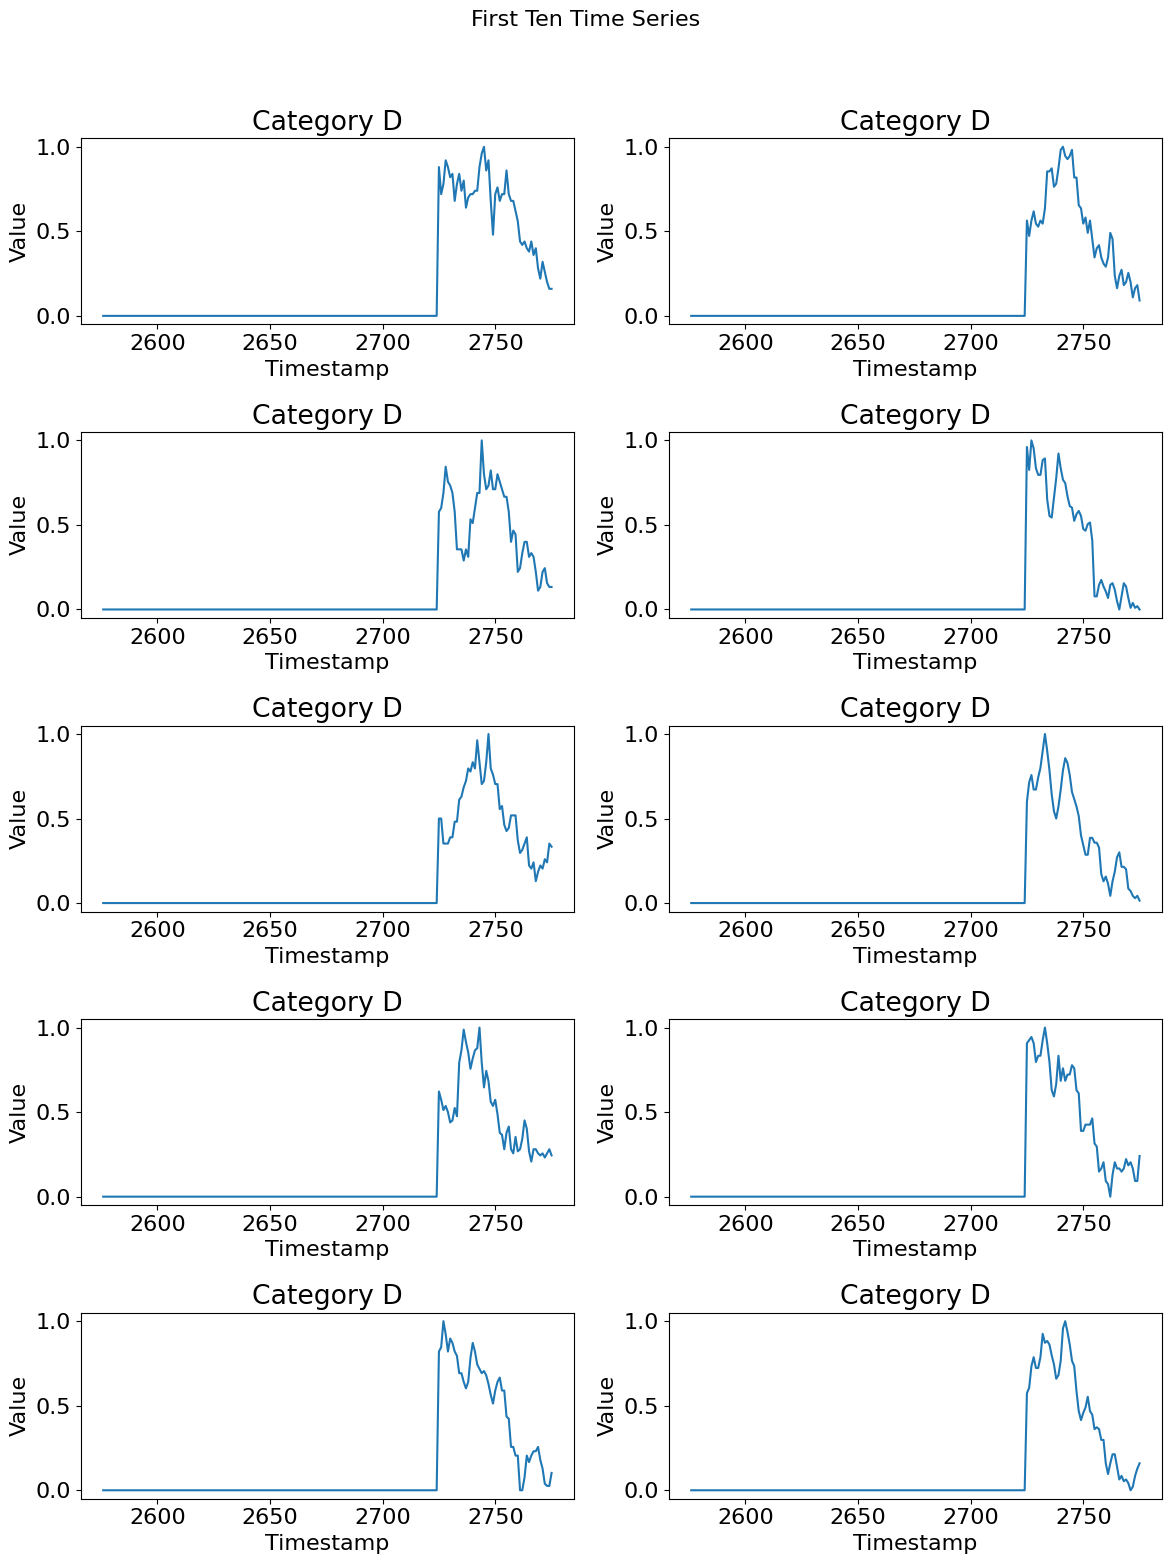

In [ ]:
j = random.randrange(40000)
def inspect_dataframe(df):
  first_ten_columns = df.iloc[-200:, j:j+10]
  # Create ten separate subplots
  fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 16))
  fig.suptitle('First Ten Time Series', fontsize=16)

  # Flatten the axes array for easier iteration
  axes = axes.flatten()

  # Plot each time series in a separate subplot
  for i, (column, ax) in enumerate(zip(first_ten_columns.columns, axes)):
      ax.plot(first_ten_columns.index, first_ten_columns[column])
      ax.set_title(f'Category {categories[j+i]}')
      ax.set_xlabel('Timestamp')
      ax.set_ylabel('Value')

  # Adjust layout for better spacing
  plt.tight_layout(rect=[0, 0, 1, 0.96])

  # Show the plots
  plt.show()

inspect_dataframe(df_transposed)

###Build sequences

In [ ]:
X_train_raw = df_transposed

In [ ]:
# Function to extract valid interval for a given time series index
def get_valid_interval(df, ar_valid, ts_index):
    start, end = ar_valid[ts_index, 0], ar_valid[ts_index, 1]
    valid_interval = df.iloc[start:end+1,ts_index ]
    return valid_interval

#print( get_valid_interval(df_transposed,valid_periods,0) )

In [ ]:
def build_sequences(df, window=200, stride=10, telescope=18):


    # Sanity check to avoid runtime errors
    assert window % stride == 0

    #for each column (time serie)
        #get only the valid sequence
        #compute padding


    data_sequence = []
    labels_sequence = []
    categories_extend = []

    for series_index in range(df.shape[1]) :

        #get only the valid part of each serie
        serie=get_valid_interval(df_transposed,valid_periods,series_index)
        valid_serie = serie.copy().values
        #TESTING
        #print(valid_serie)
        #print(len(valid_serie))

        if(len(valid_serie) != len(valid_serie)%stride+telescope):
          #check size of time series
          padding_check = len(valid_serie)%stride
          if(padding_check != 0): #true = serve il padding
              padding_len = stride - len(valid_serie)%stride # Compute padding length
              # We create an array of zeros and we concatenate it to the samples and lables
              padding = np.zeros((padding_len), dtype='float32')
              valid_serie = np.concatenate((padding,valid_serie))

          #concatenate telescope
          valid_serie=np.concatenate((np.zeros((telescope), dtype='float32'), valid_serie))

        if(len(valid_serie)>=window):
              for idx in np.arange(0,len(valid_serie)-window-telescope,stride):
                  data_sequence.append(valid_serie[idx:idx+window])
                  labels_sequence.append(valid_serie[idx+window:idx+window+telescope])
                  #print(len(data_sequence))
                  categories_extend.append(categories[series_index])

    data_s = np.array(data_sequence)
    labels = np.array(labels_sequence)
    return data_s, labels, categories_extend



In [ ]:
X_train_built, y_train_built, cat = build_sequences(X_train_raw)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_built, y_train_built, test_size = 30)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(261428, 200)
(30, 200)
(261428, 18)
(30, 18)


In [ ]:
window = 200
stride = 10
telescope = 18

In [ ]:
#expand dimension
X_train=np.expand_dims(X_train,axis=2)
y_train=np.expand_dims(y_train,axis=2)
X_test=np.expand_dims(X_test,axis=2)
y_test=np.expand_dims(y_test,axis=2)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
print(input_shape)
print(output_shape)

(200, 1)
(18, 1)


In [ ]:
def transformer_decoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization

    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="gelu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [ ]:
class PositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, embed_dim, mask_zero, **kwargs):
        """
        Initialize the layers for token and position embeddings.

        Args:
        maxlen (int): The maximum length of the input sequences.
        embed_dim (int): The dimension of the embedding vectors.
        """
        super().__init__(**kwargs)
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim, mask_zero=mask_zero)

    def call(self, x):
        """
        Perform the embedding of positions and return their sum.

        Args:
        x (tf.Tensor): The input tensor containing token indices.

        Returns:
        tf.Tensor: The tensor resulting from adding token and position embeddings.
        """
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [ ]:

def build_decoder_model(input_shape, output_shape, head_size, num_heads, emb_size, num_dec, ff_dim, dropout):

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')


    x = PositionEmbedding(200, emb_size, mask_zero= True)(input_layer)

    for _ in range(num_dec):
      x = transformer_decoder(x, head_size, num_heads, ff_dim, dropout)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='gelu', data_format='channels_first', name='conv1')(x)
    x = tfkl.GlobalAveragePooling1D(data_format='channels_first')(x)

    decoder_outputs= tfkl.Dense(output_shape[0], activation= 'linear')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=decoder_outputs, name='decoder_only_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

In [ ]:
def transformer_teaching_train(model, X_train_curr, y_train_curr):
    model.train_on_batch(x=X_train_curr, y=y_train_curr)

Model: "decoder_only_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 position_embedding_2 (Posi  (None, 200, 128)             25600     ['input_layer[0][0]']         
 tionEmbedding)                                                                                   
                                                                                                  
 multi_head_attention_6 (Mu  (None, 200, 128)             131968    ['position_embedding_2[0][0]',
 ltiHeadAttention)                                                   'position_embedding_2[0][0]']
                                                                                 

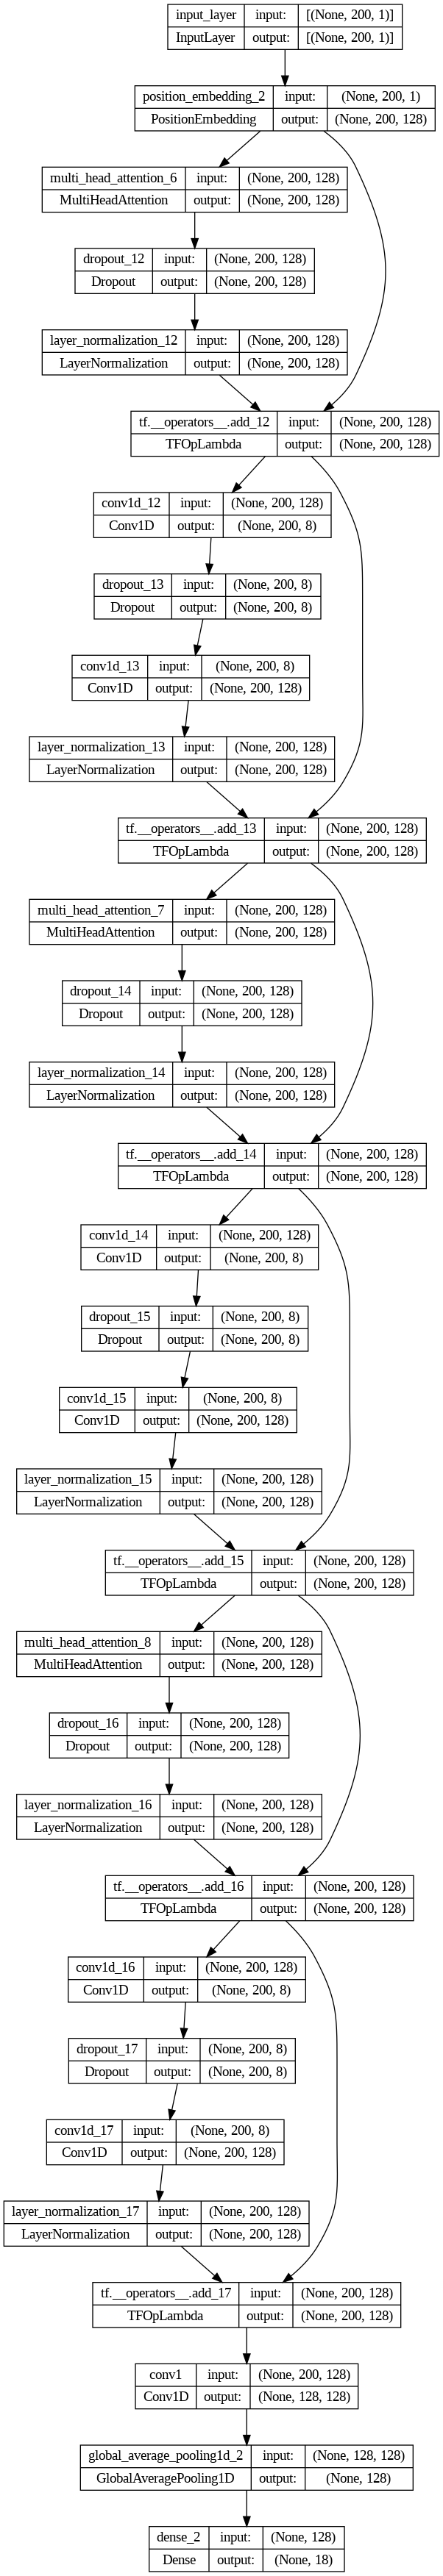

In [ ]:
model = build_decoder_model(
    input_shape,
    output_shape,
    head_size = 64,
    num_heads= 4,
    emb_size= 128,
    num_dec = 3,
    ff_dim = 8,
    dropout = 0.1)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.02,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.1, min_lr=1e-6),
        tfk.callbacks.ModelCheckpoint("checkpointDecoderGenerator", verbose=1,save_best_only=True )
    ]
).history

Epoch 1/200
4004/4004 [==============================] - ETA: 0s - loss: 0.0125
Epoch 1: val_loss improved from inf to 0.01035, saving model to checkpointDecoderGenerator
4004/4004 [==============================] - 106s 24ms/step - loss: 0.0125 - val_loss: 0.0104 - lr: 0.0010
Epoch 2/200
4002/4004 [============================>.] - ETA: 0s - loss: 0.0096
Epoch 2: val_loss improved from 0.01035 to 0.00950, saving model to checkpointDecoderGenerator
4004/4004 [==============================] - 96s 24ms/step - loss: 0.0096 - val_loss: 0.0095 - lr: 0.0010
Epoch 3/200
4003/4004 [============================>.] - ETA: 0s - loss: 0.0092
Epoch 3: val_loss did not improve from 0.00950
4004/4004 [==============================] - 92s 23ms/step - loss: 0.0092 - val_loss: 0.0095 - lr: 0.0010
Epoch 4/200
4002/4004 [============================>.] - ETA: 0s - loss: 0.0089
Epoch 4: val_loss improved from 0.00950 to 0.00885, saving model to checkpointDecoderGenerator
4004/4004 [======================

In [ ]:
 model.save('DecoderStride10')

In [ ]:
print(X_test.shape)

(294699, 200)


In [ ]:
print(y_test.shape)

(294699, 10)


In [ ]:
y_test_try=np.delete(y_test, -1, axis= 1)

In [ ]:
print(y_test_try.shape)

(294699, 9)


Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (294699, 10, 1)
Mean Squared Error: 0.007913719862699509
Mean Absolute Error: 0.056607797741889954
